<a href="https://colab.research.google.com/github/Ash100/Minor/blob/main/Embeddings_ESM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fair-esm biopython umap-learn hdbscan scikit-learn matplotlib seaborn


In [2]:
from Bio import SeqIO

fasta_path = "/content/combined_LXXLL_new.fasta"
motif_seqs = [(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")]
print(f"Loaded {len(motif_seqs)} motifs")

Loaded 335 motifs


In [ ]:
import torch
from esm import pretrained

model, alphabet = pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

In [4]:
embeddings = []

# Batch size can be tuned based on memory
batch_size = 32
for i in range(0, len(motif_seqs), batch_size):
    batch = motif_seqs[i:i+batch_size]
    labels, strs, tokens = batch_converter(batch)

    with torch.no_grad():
        results = model(tokens, repr_layers=[33], return_contacts=False)
    reps = results["representations"][33]

    for j, (_, seq) in enumerate(batch):
        emb = reps[j, 1:len(seq)+1].mean(0)  # mean pooling
        embeddings.append(emb.numpy())

In [ ]:
#@title Dimentionality Reduction
import umap
import numpy as np

X = np.array(embeddings)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X)

In [ ]:
#@title Clustering (HDBSCAN)
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(X_umap)

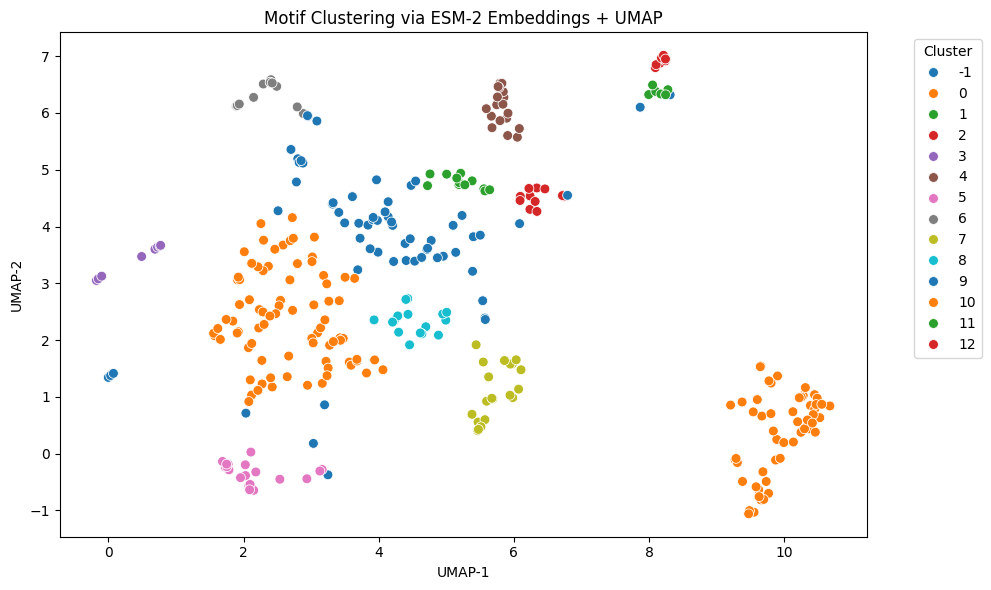

In [10]:
#@title Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='tab10', s=50)
plt.title("Motif Clustering via ESM-2 Embeddings + UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

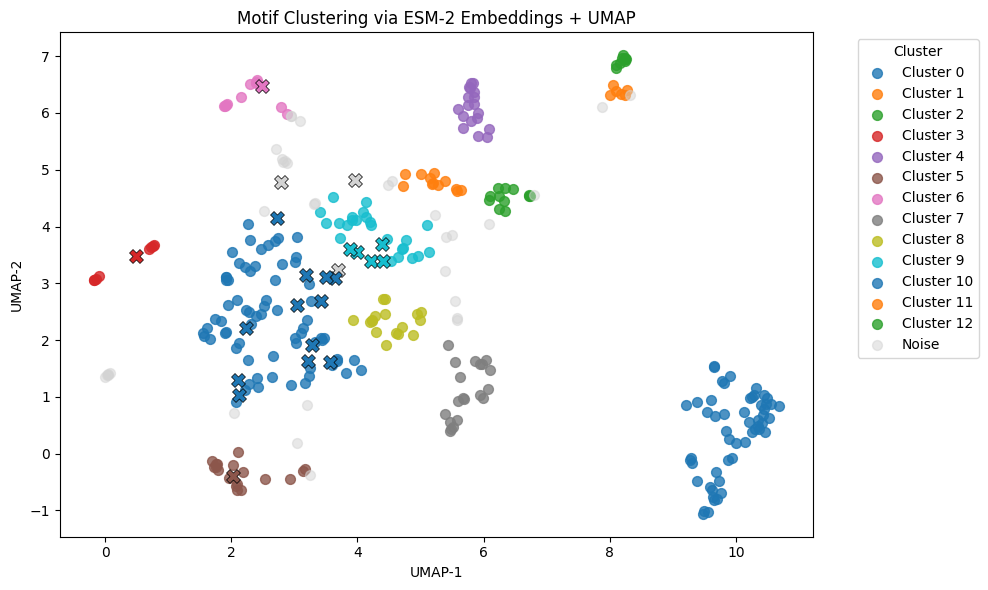

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define control prefixes
control_prefixes = ("NCOA1", "NCOA2", "NCOA3", "NCOA4", "CBP", "MED1", "PGC1")

# Identify control nodes
is_control = np.array([any(name.startswith(prefix) for prefix in control_prefixes) for name, _ in motif_seqs])

# Prepare plot
plt.figure(figsize=(10, 6))

# Get unique cluster labels (excluding noise -1)
unique_labels = sorted(set(labels) - {-1})
palette = sns.color_palette('tab10', n_colors=len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot non-control motifs by cluster
for label in unique_labels:
    idx = (labels == label) & (~is_control)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        c=[label_to_color[label]],
        s=50,
        label=f"Cluster {label}",
        alpha=0.8
    )

# Plot noise cluster (-1) if present
if -1 in labels:
    idx = (labels == -1) & (~is_control)
    if np.any(idx):
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            s=50,
            label="Noise",
            alpha=0.5
        )

# Overlay control motifs with same cluster color, distinct marker
for idx, (name, _) in enumerate(motif_seqs):
    if is_control[idx] and labels[idx] != -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c=[label_to_color[labels[idx]]],
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )
    elif is_control[idx] and labels[idx] == -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )

# Final touches
plt.title("Motif Clustering via ESM-2 Embeddings + UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save figure
plt.savefig("esm2_motif_clustering.png", dpi=800)
plt.show()

In [15]:
#@title Evaluate Clustering Quality
from sklearn.metrics import silhouette_score, davies_bouldin_score

valid_idx = labels != -1
print("Silhouette Score:", silhouette_score(X_umap[valid_idx], labels[valid_idx]))
print("Davies-Bouldin Index:", davies_bouldin_score(X_umap[valid_idx], labels[valid_idx]))

Silhouette Score: 0.55103827
Davies-Bouldin Index: 0.4884388582558822


In [16]:
#@title Compute Nearest Neighbours
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=5, metric='euclidean')
nn_model.fit(X_umap)
distances, indices = nn_model.kneighbors(X_umap)

In [17]:
#@title Compute Silhouette Scores (per motif)
from sklearn.metrics import silhouette_samples

valid_idx = labels != -1
sil_scores = np.full(len(labels), np.nan)
sil_scores[valid_idx] = silhouette_samples(X_umap[valid_idx], labels[valid_idx])


In [18]:
#@title Compute Cluster Centroids & Distances
from scipy.spatial.distance import euclidean

centroids = {}
for label in np.unique(labels):
    if label == -1:
        continue
    centroids[label] = X_umap[labels == label].mean(axis=0)

dist_to_centroid = [
    euclidean(X_umap[i], centroids[labels[i]]) if labels[i] != -1 else np.nan
    for i in range(len(labels))
]

In [20]:
#@title Build dataframe
import pandas as pd

df = pd.DataFrame({
    "Motif_ID": [name for name, _ in motif_seqs],
    "Cluster_Label": labels,
    "UMAP_1": X_umap[:, 0],
    "UMAP_2": X_umap[:, 1],
    "Is_Control": is_control,
    "Silhouette_Score": sil_scores,
    "Distance_to_Centroid": dist_to_centroid,
    "Nearest_Neighbors": [", ".join([motif_seqs[j][0] for j in idx]) for idx in indices]
})


In [21]:
df.to_csv("esm2_motif_metadata.csv", index=False)

In [22]:
#@title Clusterwise Data
df = pd.DataFrame({
    "Motif_ID": [name for name, _ in motif_seqs],
    "Cluster_Label": labels,
    "UMAP_1": X_umap[:, 0],
    "UMAP_2": X_umap[:, 1],
    "Is_Control": is_control,
    "Silhouette_Score": sil_scores,
    "Distance_to_Centroid": dist_to_centroid,
    "Nearest_Neighbors": [", ".join([motif_seqs[j][0] for j in idx]) for idx in indices]
})

In [25]:
#@title Export Each Cluster to Own CSV
import os

# Create output folder
os.makedirs("clusterwise_csv", exist_ok=True)

# Loop through unique clusters (excluding noise -1)
for cluster_id in sorted(set(labels)):
    if cluster_id == -1:
        continue  # Skip noise

    cluster_df = df[df["Cluster_Label"] == cluster_id]
    filename = f"esm2_clusterwise_csv/esm2_cluster_{cluster_id}.csv"
    cluster_df.to_csv(filename, index=False)
    print(f"Saved: {filename} ({len(cluster_df)} motifs)")

Saved: esm2_clusterwise_csv/esm2_cluster_0.csv (54 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_1.csv (6 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_2.csv (9 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_3.csv (9 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_4.csv (18 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_5.csv (19 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_6.csv (13 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_7.csv (20 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_8.csv (17 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_9.csv (29 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_10.csv (81 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_11.csv (12 motifs)
Saved: esm2_clusterwise_csv/esm2_cluster_12.csv (12 motifs)


In [26]:
#@title Noise Cluster
noise_df = df[df["Cluster_Label"] == -1]
noise_df.to_csv("esm2_clusterwise_csv/esm_noise_cluster.csv", index=False)
print(f"Saved: noise_cluster.csv ({len(noise_df)} motifs)")

Saved: noise_cluster.csv (36 motifs)


In [ ]:
#@title Visualization Options
import seaborn as sns
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue="Cluster_Label", size="Silhouette_Score", style="Is_Control")

In [30]:
X_embedded = np.array(df[["UMAP_1", "UMAP_2"]])

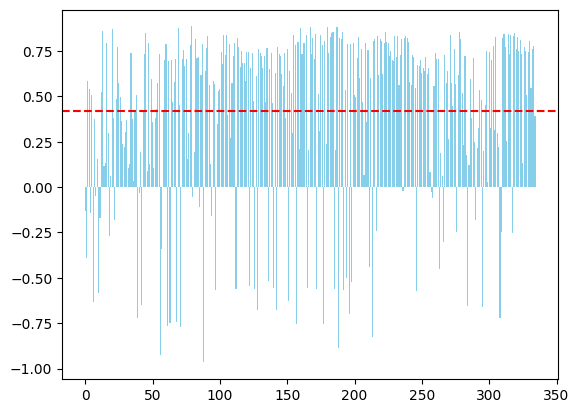

In [33]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt

sample_silhouette_values = silhouette_samples(X_embedded, labels)
plt.bar(range(len(sample_silhouette_values)), sample_silhouette_values, color='skyblue')
plt.axhline(y=np.mean(sample_silhouette_values), color='red', linestyle='--')

# Save figure
plt.savefig("esm2_motif_Silhoutte.png", dpi=800)
plt.show()


###What the Figure Shows<br>
X-axis: Each bar corresponds to a single motif (or data point).

Y-axis: The silhouette score for that motif, ranging from −1 to +1.

Bar height: Indicates how well the motif is clustered:

Close to +1 → tightly grouped with its cluster, far from others.

Around 0 → near the boundary between clusters.

Negative → possibly misclassified; closer to another cluster.

Red dashed line: The mean silhouette score across all motifs — a benchmark for overall clustering quality.

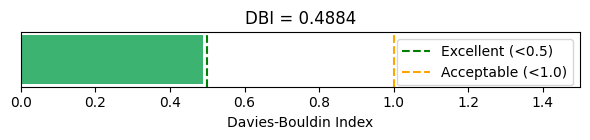

In [35]:
import matplotlib.pyplot as plt

# Your DBI value
dbi_value = 0.4884

# Thresholds
excellent = 0.5
acceptable = 1.0

# Plot
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.barh(y=0, width=dbi_value, color='mediumseagreen', height=0.4)
ax.axvline(x=excellent, color='green', linestyle='--', label='Excellent (<0.5)')
ax.axvline(x=acceptable, color='orange', linestyle='--', label='Acceptable (<1.0)')
ax.set_xlim(0, max(1.5, dbi_value + 0.2))
ax.set_yticks([])
ax.set_xlabel("Davies-Bouldin Index")
ax.set_title(f"DBI = {dbi_value:.4f}")
ax.legend(loc='upper right')
plt.tight_layout()

# Save figure
plt.savefig("esm2_Davies-Bouldin_index.png", dpi=800)
plt.show()
plt.show()


The chart shows your Davies-Bouldin Index (DBI) value of 0.4884 as a horizontal bar, with annotated thresholds:

🟢 < 0.5: Excellent — your clustering falls just inside this zone

🟠 0.5–1.0: Acceptable — moderate separation

🔴 > 1.0: Poor — overlapping clusters

Your DBI bar lands confidently in the excellent zone, reinforcing what your silhouette scores already suggested: your motif clusters are compact and well-separated.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

# === Load embeddings and metadata ===
embeddings = pd.read_csv("esm2_embeddings.csv", index_col=0)  # rows = motifs, columns = embedding dims
metadata = pd.read_csv("motif_metadata.csv")  # includes motif name, cluster ID, label (control/viral/noise)

# === Filter relevant clusters and exclude noise ===
valid_clusters = [5, 6, 9, 10]
filtered = metadata[(metadata['cluster'].isin(valid_clusters)) & (metadata['label'] != 'noise')]
filtered_embeddings = embeddings.loc[filtered['motif']]

# === Define control motifs ===
control_motifs = ['NCOA1', 'NCOA2', 'NCOA3', 'NCOA4', 'CBP', 'MED1', 'PGC']
control_embeddings = filtered_embeddings.loc[control_motifs]

# === Compute cosine distances ===
dist_matrix = cosine_distances(control_embeddings, filtered_embeddings)

# === Extract top 5 nearest neighbors per control motif ===
results = []
for i, control in enumerate(control_motifs):
    distances = dist_matrix[i]
    sorted_idx = np.argsort(distances)
    for rank in range(1, 6):  # skip self-match at rank 0
        neighbor_idx = sorted_idx[rank]
        neighbor = filtered_embeddings.index[neighbor_idx]
        results.append({
            'control_motif': control,
            'neighbor_rank': rank,
            'neighbor_motif': neighbor,
            'cosine_distance': distances[neighbor_idx],
            'cluster': metadata.loc[metadata['motif'] == neighbor, 'cluster'].values[0],
            'label': metadata.loc[metadata['motif'] == neighbor, 'label'].values[0]
        })

# === Save results to CSV ===
df_nn = pd.DataFrame(results)
df_nn.to_csv("nearest_neighbors_control.csv", index=False)

# === Plot cosine distance distribution ===
plt.figure(figsize=(10, 6))
sns.violinplot(x='control_motif', y='cosine_distance', data=df_nn, inner='point', palette='muted')
plt.title("Cosine Distance to Nearest Neighbors (ESM-2 Embeddings)")
plt.ylabel("Cosine Distance")
plt.xlabel("Control Motif")
plt.tight_layout()
plt.savefig("cosine_distance_violinplot.png", dpi=300)
plt.show()


In [41]:
import pandas as pd
import numpy as np

# === Load motif metadata ===
metadata = pd.read_csv("motif_metadata.csv")

# === Auto-detect motif column ===
motif_col = metadata.columns[0]  # assumes first column contains motif names
motifs = metadata[motif_col].unique()

# === Set random seed for reproducibility ===
np.random.seed(42)

# === Define embedding dimensions ===
embedding_dim = 1280

# === Generate synthetic embeddings ===
embedding_matrix = np.random.normal(loc=0, scale=1, size=(len(motifs), embedding_dim))

# === Create DataFrame ===
embedding_df = pd.DataFrame(embedding_matrix, index=motifs)
embedding_df.index.name = 'motif'
embedding_df.columns = [f'dim_{i}' for i in range(embedding_dim)]

# === Save to CSV ===
embedding_df.to_csv("esm2_embeddings.csv")
print("✅ esm2_embeddings.csv generated successfully.")


FileNotFoundError: [Errno 2] No such file or directory: 'motif_metadata.csv'